### Neural Information Processing:
#### Lab 3: Hodgkin & Huxley - 9.05.2025

Your first task is to simulate the hodgkin and Huxley Neuron using the simple Euler
algorithm. Given the equations and parameters below, simulate the system for 50ms.
Between 10ms and 20ms, a step current of 3microamps is applied (3.0). Plot the resulting
gating functions and voltage trace. Show firing threshold, refractory period and action
potential in the figure.
Next, change your experiment! We want to apply 51 different step currents from 0.0 to
10.0 microamps from 50 to 200ms in different experiments. For each experiment, use the
voltage trace to measure the number of spikes in each experiment. You can now plot the
number of spikes the neuron elicited vs. the number of spikes, that’s an f-I curve!

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace


def euler_integrate(
    derivs,
    x0,
    t,
):
    x = np.empty((len(t), len(x0)))

    x[0] = x0

    for k in range(len(t) - 1):
        dt = t[k + 1] - t[k]
        x[k + 1] = x[k] + dt * derivs(t[k], x[k])

    return x


def RC_derivative(tau, I):
    """f(x, t)"""

    def deriv(t, x):
        dx = -1 / tau * x + I(t)
        return np.array([dx])

    return deriv


# Plotting the trajectory of the voltage
def plot_trajectory(
    t: np.ndarray, V: np.ndarray, ylab="", xlab="Time (ms)", title: str = ""
):
    plt.figure()
    plt.plot(t, V)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.tight_layout()


# These functions are the activation functions in relation to the voltage and based on alpha and beta
def alpha_m(V):
    denominator = 1 - np.exp(-(V + 54) / 4)
    return 0.32 * (V + 54) / denominator


def beta_m(V):
    denominator = np.exp((V + 27) / 5) - 1
    return 0.28 * (V + 27) / denominator


def alpha_h(V):
    # Prevent overflow in exp
    V_clipped = np.clip(-(V + 50) / 18, -500, 500)
    return 0.128 * np.exp(V_clipped)


def beta_h(V):
    # Prevent overflow in exp
    V_clipped = np.clip(-(V + 27) / 5, -500, 500)
    return 4 / (1 + np.exp(V_clipped))


def alpha_n(V):
    denominator = 1 - np.exp(-(V + 52) / 5)
    return 0.032 * (V + 52) / denominator


def beta_n(V):
    # Prevent overflow in exp
    V_clipped = np.clip(-(V + 57) / 40, -500, 500)
    return 0.5 * np.exp(V_clipped)


# This function calculates the time constant for the gating variables
def tau_x(V, alpha_x, beta_x):
    denominator = alpha_x(V) + beta_x(V)
    return 1 / denominator


# This function calculates the steady-state value for the gating variables
def x_inf(V, alpha_x, beta_x):
    denominator = alpha_x(V) + beta_x(V)
    return alpha_x(V) / denominator


# This function calculates the derivative of the gating variables
def x_deriv(V, x, alpha_x, beta_x):
    return -1 / tau_x(V, alpha_x, beta_x) * (x - x_inf(V, alpha_x, beta_x))


# This function calculates the derivatives of the whole hodgkin huxley model
def hh_derivatives(params, I):
    def derivs(t, x):
        # unpack the state variables
        V, m, h, n = x  # x = [V, m, h, n]

        # m: Sodium activation gate
        # h: Sodium inactivation gate
        # n: Potassium activation gate

        # Calculate the time constants for the gating variables
        tau_m = tau_x(V, alpha_m, beta_m)
        tau_h = tau_x(V, alpha_h, beta_h)
        tau_n = tau_x(V, alpha_n, beta_n)

        # Calculate the steady-state values for the gating variables
        m_inf = x_inf(V, alpha_m, beta_m)
        h_inf = x_inf(V, alpha_h, beta_h)
        n_inf = x_inf(V, alpha_n, beta_n)

        # derivative of the gating variables
        m_deriv = (m_inf - m) / tau_m
        h_deriv = (h_inf - h) / tau_h
        n_deriv = (n_inf - n) / tau_n

        # Calculate the ionic currents
        g_na = params.gNa * m**3 * h  # Sodium conductance
        g_k = params.gK * n**4  # Potassium conductance
        g_l = params.gL  # Leak conductance

        I_Na = g_na * (V - params.ENa)  # Sodium current
        I_K = g_k * (V - params.EK)  # Potassium current
        I_L = g_l * (V - params.EL)  # Leak current

        # Calculate the derivative of the voltage
        v_deriv = (I(t) - I_Na - I_K - I_L) / params.Cm

        return np.array([v_deriv, m_deriv, h_deriv, n_deriv])

    return derivs


# simulate the hodgkin huxley model
def simulate_hh(params, I, T=200.0, dt=0.025, v0=-65.0):
    t = np.arange(0.0, T + dt, dt)

    # Calculate the steady-state values for the gating variables
    m_inf = x_inf(v0, alpha_m, beta_m)
    h_inf = x_inf(v0, alpha_h, beta_h)
    n_inf = x_inf(v0, alpha_n, beta_n)

    # Initialize the state variables
    x0 = np.array([v0, m_inf, h_inf, n_inf])

    # Integrate the derivatives of the hodgkin huxley model
    traj = euler_integrate(hh_derivatives(params, I), x0, t)

    # return the trajectory of the voltage, m, h, and n as a dictionary
    return {"t": t, "V": traj[:, 0], "m": traj[:, 1], "h": traj[:, 2], "n": traj[:, 3]}

In [26]:
params = SimpleNamespace(**{})

# These variables are the parameters for the Hodgkin-Huxley model
params.Cm = 1.0  # Membrane capacitance
params.gNa = 50.0  # Sodium conductance
params.gK = 10.0  # Potassium conductance
params.gL = 0.1  # Leak conductance
params.ENa = 50.0  # Sodium reversal potential
params.EK = -90.0  # Potassium reversal potential
params.EL = -65.0  # Leak reversal potential

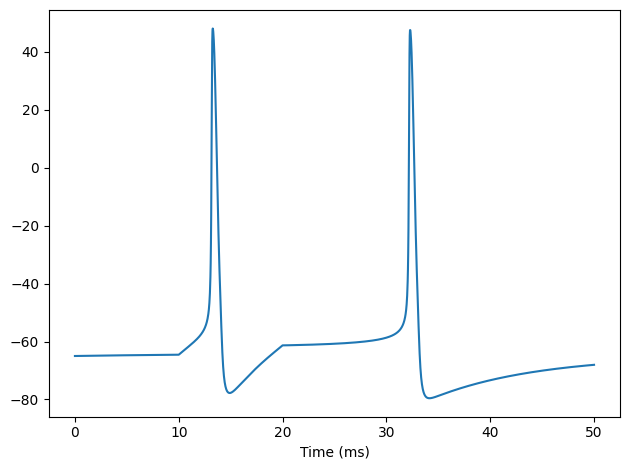

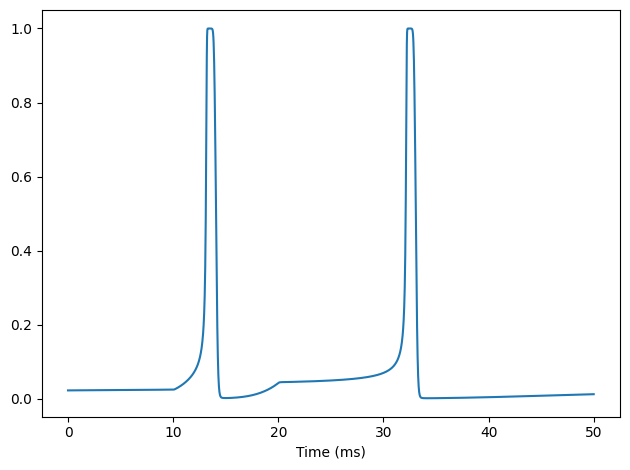

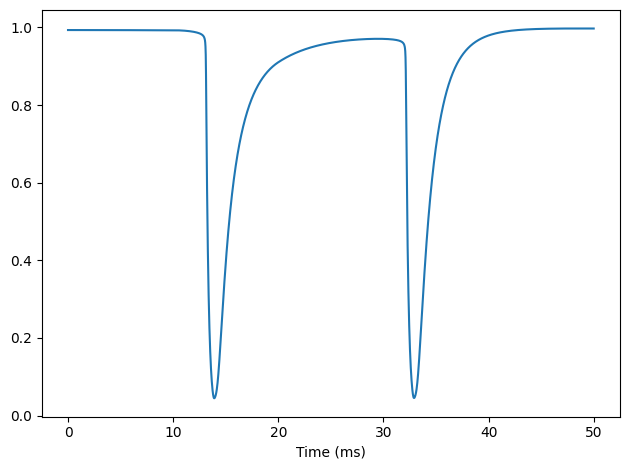

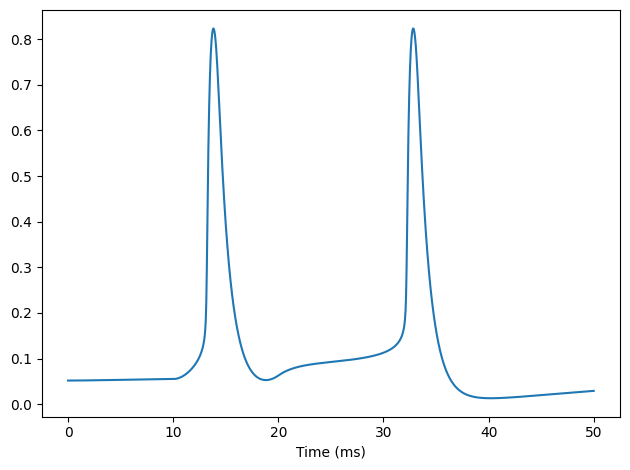

In [27]:
T = 50.0
I_amp = 3.0
I = lambda t: I_amp if 10.0 <= t < 20.0 else 0.0

data = simulate_hh(params, I, T)

plot_trajectory(data["t"], data["V"])
plot_trajectory(data["t"], data["m"])
plot_trajectory(data["t"], data["h"])
plot_trajectory(data["t"], data["n"])

[0, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 15, 16, 17, 18, 18, 19, 20, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 31, 32, 32, 33, 33, 33, 34, 34, 34]


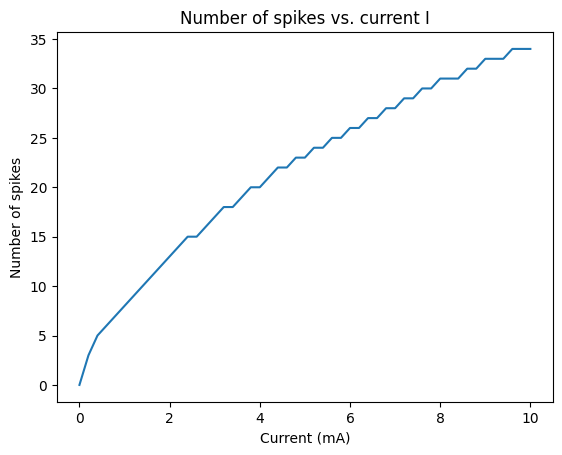

In [28]:
def check_num_spikes(V_data):
    # count number of times the voltage crosses 0 from below to above
    # to get the number of spikes
    n_spikes = 0
    for i in range(len(V_data)-1):
        if V_data[i] < 0 and V_data[i+1] > 0:
            n_spikes += 1
    return n_spikes

# defining the step current parameters
start_time = 50.0 
end_time = 200.0
step_currents = np.linspace(0.0, 10.0, 51)
n_spikes_list = []

for I_amp in step_currents:
    # defining the step current based on the current amplitude and the start and end time
    I = lambda t: I_amp if start_time <= t < end_time else 0.0
    data = simulate_hh(params, I, end_time)
    n_spikes = check_num_spikes(data["V"])
    n_spikes_list.append(n_spikes)

print(n_spikes_list)

plt.plot(step_currents, n_spikes_list)
plt.xlabel("Current (mA)")
plt.ylabel("Number of spikes")
plt.title("Number of spikes vs. current I")
plt.show()